## 1. Import Required Libraries

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
from datetime import datetime

# TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# Sklearn metrics
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_curve, roc_auc_score
)

# Warnings
import warnings
warnings.filterwarnings('ignore')

print(f"TensorFlow Version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

2025-11-26 02:55:29.723769: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-26 02:55:29.742938: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-26 02:55:30.440157: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-26 02:55:34.627306: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To tur

TensorFlow Version: 2.20.0
GPU Available: []


2025-11-26 02:55:35.566717: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


## 2. Configuration and Setup

In [2]:
# Project paths
BASE_DIR = Path('/home/twize/Desktop/ML-summatives')
TRAIN_DIR = BASE_DIR / 'data' / 'train'
TEST_DIR = BASE_DIR / 'data' / 'test'
MODEL_DIR = BASE_DIR / 'models'

# Hyperparameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 25
LEARNING_RATE = 0.0001
CLASS_NAMES = ['cats', 'dogs']

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print(f"Train directory: {TRAIN_DIR}")
print(f"Test directory: {TEST_DIR}")
print(f"Model directory: {MODEL_DIR}")
print(f"\nConfiguration:")
print(f"  Image Size: {IMG_SIZE}")
print(f"  Batch Size: {BATCH_SIZE}")
print(f"  Epochs: {EPOCHS}")
print(f"  Learning Rate: {LEARNING_RATE}")

Train directory: /home/twize/Desktop/ML-summatives/data/train
Test directory: /home/twize/Desktop/ML-summatives/data/test
Model directory: /home/twize/Desktop/ML-summatives/models

Configuration:
  Image Size: (224, 224)
  Batch Size: 32
  Epochs: 25
  Learning Rate: 0.0001


## 3. Data Exploration

Dataset Statistics:

Training Set:
  Cats: 4,000
  Dogs: 4,005
  Total: 8,005

Test Set:
  Cats: 1,011
  Dogs: 1,012
  Total: 2,023


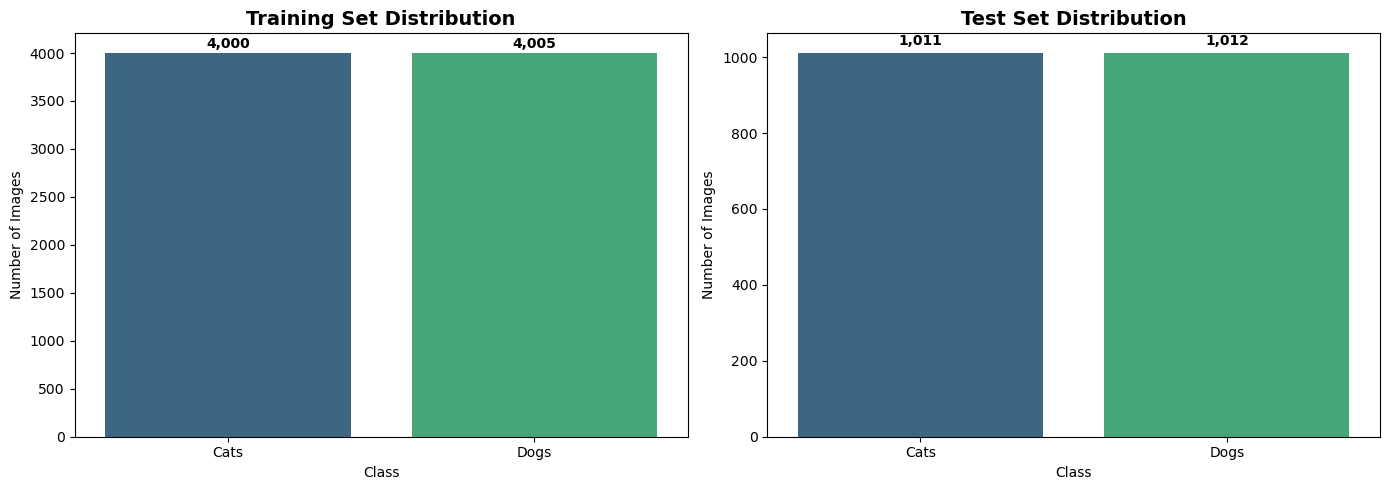


Dataset is well-balanced for binary classification.


In [3]:
# Count images in each class
train_cats = len(list((TRAIN_DIR / 'cats').glob('*.jpg')))
train_dogs = len(list((TRAIN_DIR / 'dogs').glob('*.jpg')))
test_cats = len(list((TEST_DIR / 'cats').glob('*.jpg')))
test_dogs = len(list((TEST_DIR / 'dogs').glob('*.jpg')))

print("Dataset Statistics:")
print(f"\nTraining Set:")
print(f"  Cats: {train_cats:,}")
print(f"  Dogs: {train_dogs:,}")
print(f"  Total: {train_cats + train_dogs:,}")

print(f"\nTest Set:")
print(f"  Cats: {test_cats:,}")
print(f"  Dogs: {test_dogs:,}")
print(f"  Total: {test_cats + test_dogs:,}")

# Visualization 1: Class Distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Training set distribution
train_data = pd.DataFrame({
    'Class': ['Cats', 'Dogs'],
    'Count': [train_cats, train_dogs]
})
sns.barplot(data=train_data, x='Class', y='Count', ax=axes[0], palette='viridis')
axes[0].set_title('Training Set Distribution', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Number of Images')
for i, v in enumerate(train_data['Count']):
    axes[0].text(i, v + 50, f"{v:,}", ha='center', fontweight='bold')

# Test set distribution
test_data = pd.DataFrame({
    'Class': ['Cats', 'Dogs'],
    'Count': [test_cats, test_dogs]
})
sns.barplot(data=test_data, x='Class', y='Count', ax=axes[1], palette='viridis')
axes[1].set_title('Test Set Distribution', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Number of Images')
for i, v in enumerate(test_data['Count']):
    axes[1].text(i, v + 20, f"{v:,}", ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

print("\nDataset is well-balanced for binary classification.")

## 4. Sample Image Visualization

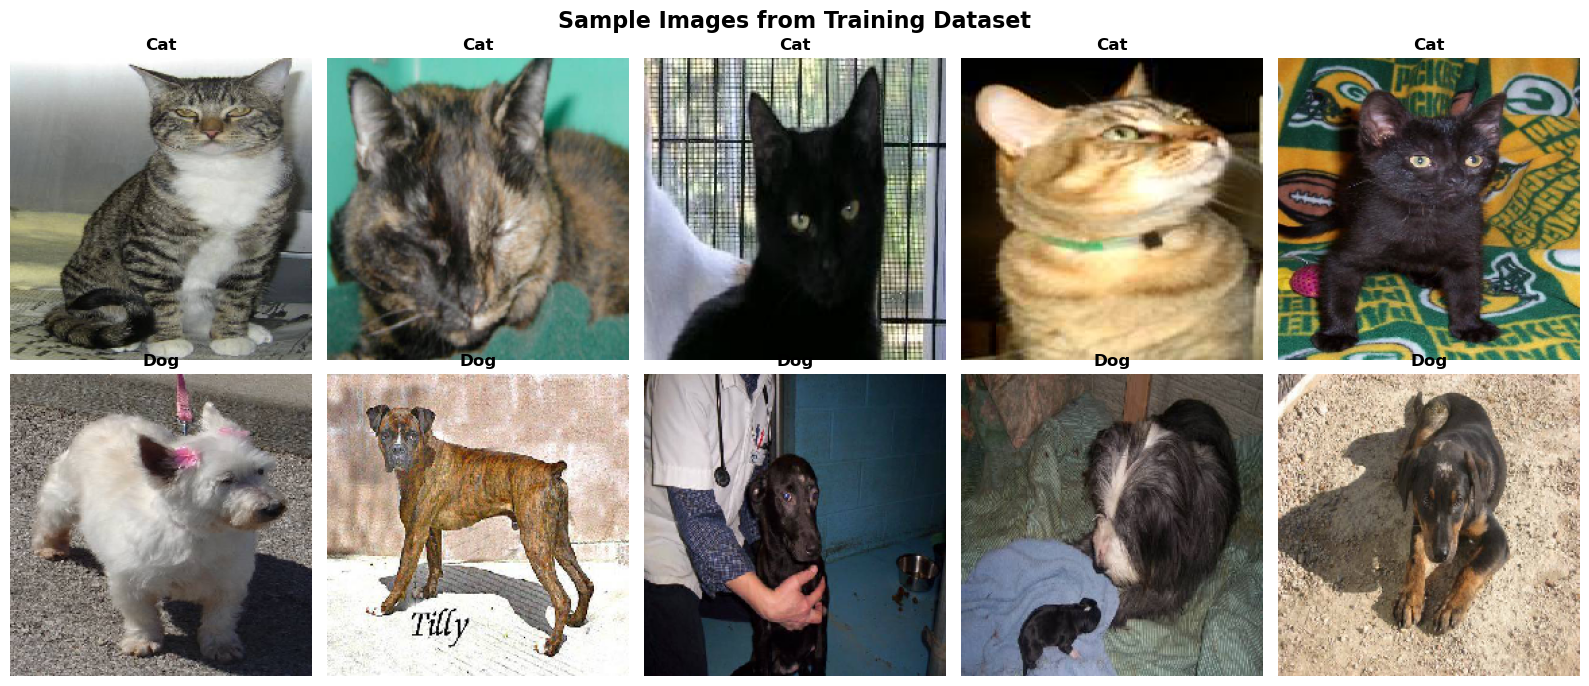

In [4]:
# Visualization 2: Sample Images from Dataset
fig, axes = plt.subplots(2, 5, figsize=(16, 7))
fig.suptitle('Sample Images from Training Dataset', fontsize=16, fontweight='bold')

# Display 5 cats
cat_images = list((TRAIN_DIR / 'cats').glob('*.jpg'))[:5]
for idx, img_path in enumerate(cat_images):
    img = load_img(img_path, target_size=IMG_SIZE)
    axes[0, idx].imshow(img)
    axes[0, idx].set_title('Cat', fontsize=12, fontweight='bold')
    axes[0, idx].axis('off')

# Display 5 dogs
dog_images = list((TRAIN_DIR / 'dogs').glob('*.jpg'))[:5]
for idx, img_path in enumerate(dog_images):
    img = load_img(img_path, target_size=IMG_SIZE)
    axes[1, idx].imshow(img)
    axes[1, idx].set_title('Dog', fontsize=12, fontweight='bold')
    axes[1, idx].axis('off')

plt.tight_layout()
plt.show()

## 5. Data Preprocessing and Augmentation

**Optimization Techniques Applied:**
1. **Data Augmentation** - Increases dataset diversity
2. **Normalization** - Scales pixel values to [0, 1]
3. **Random transformations** - Prevents overfitting

In [5]:
# Training data generator with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # 20% for validation
)

# Test data generator (only rescaling, no augmentation)
test_datagen = ImageDataGenerator(rescale=1./255)

# Training set
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training',
    shuffle=True,
    seed=42
)

# Validation set
validation_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation',
    shuffle=False,
    seed=42
)

# Test set
test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {validation_generator.samples}")
print(f"Test samples: {test_generator.samples}")
print(f"\nClass indices: {train_generator.class_indices}")

Found 6404 images belonging to 2 classes.
Found 1601 images belonging to 2 classes.
Found 2023 images belonging to 2 classes.
Training samples: 6404
Validation samples: 1601
Test samples: 2023

Class indices: {'cats': 0, 'dogs': 1}


## 6. Visualization of Augmented Images

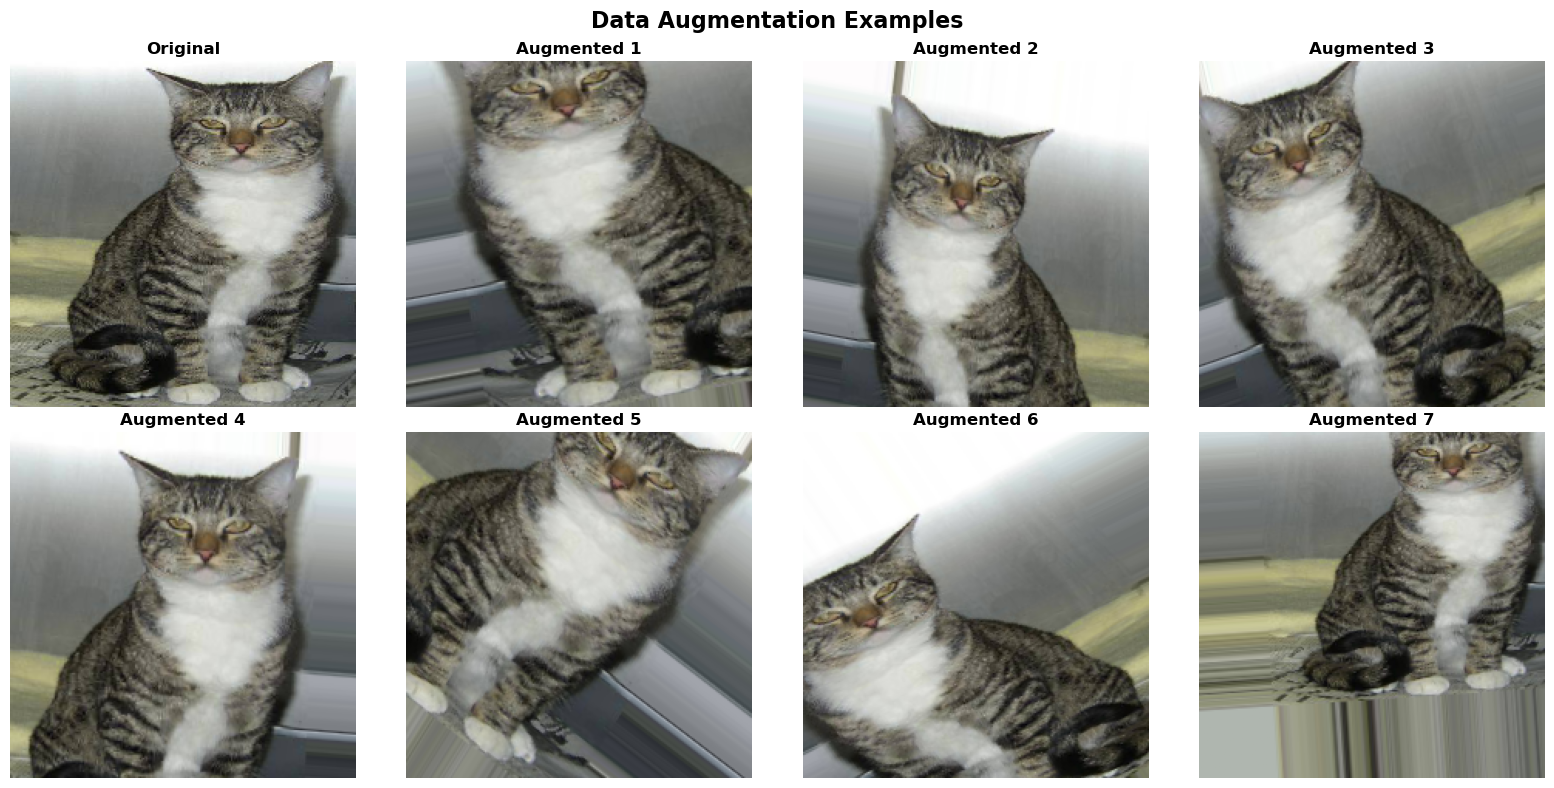

In [6]:
# Visualization 3: Data Augmentation Effects
sample_img_path = list((TRAIN_DIR / 'cats').glob('*.jpg'))[0]
sample_img = load_img(sample_img_path, target_size=IMG_SIZE)
sample_array = img_to_array(sample_img)
sample_array = sample_array.reshape((1,) + sample_array.shape)

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
fig.suptitle('Data Augmentation Examples', fontsize=16, fontweight='bold')

# Original image
axes[0, 0].imshow(sample_img)
axes[0, 0].set_title('Original', fontweight='bold')
axes[0, 0].axis('off')

# Generate augmented images
aug_gen = train_datagen.flow(sample_array, batch_size=1)
positions = [(0, 1), (0, 2), (0, 3), (1, 0), (1, 1), (1, 2), (1, 3)]

for i, (row, col) in enumerate(positions):
    aug_img = next(aug_gen)[0]
    axes[row, col].imshow(aug_img)
    axes[row, col].set_title(f'Augmented {i+1}', fontweight='bold')
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

## 7. Model Architecture with Transfer Learning

**Using VGG16 as Pretrained Model:**
- Pretrained on ImageNet
- Fine-tuning top layers
- Custom classification head

In [7]:
# Load pretrained VGG16 model
base_model = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)
)

# Freeze base model layers
base_model.trainable = False

# Build custom model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])

# Compile model
model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

print("Model Architecture:")
model.summary()

Model Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,879,041 (56.76 MB)

 Trainable params: 164,353 (642.00 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

## 8. Callbacks Configuration

**Optimization Techniques:**
1. **Early Stopping** - Prevents overfitting
2. **Model Checkpoint** - Saves best model
3. **Learning Rate Reduction** - Adaptive learning

In [8]:
# Define callbacks
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        filepath=str(MODEL_DIR / 'best_model.h5'),
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    )
]

print("Callbacks configured:")
print("  - Early Stopping (patience=5)")
print("  - Model Checkpoint (save best model)")
print("  - Learning Rate Reduction (factor=0.5, patience=3)")

Callbacks configured:
  - Early Stopping (patience=5)
  - Model Checkpoint (save best model)
  - Learning Rate Reduction (factor=0.5, patience=3)


## 9. Model Training

In [11]:
# Train the model
print("Starting model training...\n")

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    callbacks=callbacks,
    verbose=1
)

print("\nTraining completed!")

Starting model training...

Epoch 1/25
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.5417 - loss: 0.6904 - precision: 0.5413 - recall: 0.5644
Epoch 1: val_accuracy improved from None to 0.66875, saving model to /home/twize/Desktop/ML-summatives/models/best_model.h5


200/200 ━━━━━━━━━━━━━━━━━━━━ 1713s 9s/step - accuracy: 0.5647 - loss: 0.6782 - precision: 0.5632 - recall: 0.5710 - val_accuracy: 0.6687 - val_loss: 0.6214 - val_precision: 0.6119 - val_recall: 0.9225 - learning_rate: 1.0000e-04
Epoch 2/25
  1/200 ━━━━━━━━━━━━━━━━━━━━ 22:17 7s/step - accuracy: 0.5938 - loss: 0.6329 - precision: 0.7647 - recall: 0.5909
Epoch 2: val_accuracy improved from 0.66875 to 0.68375, saving model to /home/twize/Desktop/ML-summatives/models/best_model.h5


200/200 ━━━━━━━━━━━━━━━━━━━━ 342s 2s/step - accuracy: 0.5938 - loss: 0.6329 - precision: 0.7647 - recall: 0.5909 - val_accuracy: 0.6837 - val_loss: 0.6200 - val_precision: 0.6227 - val_recall: 0.9325 - learning_rate: 1.0000e-04
Epoch 3/25
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.6534 - loss: 0.6288 - precision: 0.6548 - recall: 0.6643
Epoch 3: val_accuracy improved from 0.68375 to 0.78562, saving model to /home/twize/Desktop/ML-summatives/models/best_model.h5


200/200 ━━━━━━━━━━━━━━━━━━━━ 1699s 8s/step - accuracy: 0.6733 - loss: 0.6082 - precision: 0.6790 - recall: 0.6585 - val_accuracy: 0.7856 - val_loss: 0.5237 - val_precision: 0.7723 - val_recall: 0.8100 - learning_rate: 1.0000e-04
Epoch 4/25
  1/200 ━━━━━━━━━━━━━━━━━━━━ 22:09 7s/step - accuracy: 0.7812 - loss: 0.5028 - precision: 0.7222 - recall: 0.8667
Epoch 4: val_accuracy did not improve from 0.78562
200/200 ━━━━━━━━━━━━━━━━━━━━ 342s 2s/step - accuracy: 0.7812 - loss: 0.5028 - precision: 0.7222 - recall: 0.8667 - val_accuracy: 0.7837 - val_loss: 0.5204 - val_precision: 0.7671 - val_recall: 0.8150 - learning_rate: 1.0000e-04
Epoch 5/25
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.7483 - loss: 0.5377 - precision: 0.7571 - recall: 0.7407
Epoch 5: val_accuracy improved from 0.78562 to 0.81687, saving model to /home/twize/Desktop/ML-summatives/models/best_model.h5


200/200 ━━━━━━━━━━━━━━━━━━━━ 1700s 9s/step - accuracy: 0.7509 - loss: 0.5258 - precision: 0.7592 - recall: 0.7361 - val_accuracy: 0.8169 - val_loss: 0.4389 - val_precision: 0.8229 - val_recall: 0.8075 - learning_rate: 1.0000e-04
Epoch 6/25
  1/200 ━━━━━━━━━━━━━━━━━━━━ 22:13 7s/step - accuracy: 0.7812 - loss: 0.4638 - precision: 0.7500 - recall: 0.6923
Epoch 6: val_accuracy improved from 0.81687 to 0.82000, saving model to /home/twize/Desktop/ML-summatives/models/best_model.h5


200/200 ━━━━━━━━━━━━━━━━━━━━ 343s 2s/step - accuracy: 0.7812 - loss: 0.4638 - precision: 0.7500 - recall: 0.6923 - val_accuracy: 0.8200 - val_loss: 0.4333 - val_precision: 0.8316 - val_recall: 0.8025 - learning_rate: 1.0000e-04
Epoch 7/25
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.7913 - loss: 0.4613 - precision: 0.8081 - recall: 0.7595
Epoch 7: val_accuracy improved from 0.82000 to 0.84438, saving model to /home/twize/Desktop/ML-summatives/models/best_model.h5


200/200 ━━━━━━━━━━━━━━━━━━━━ 1701s 9s/step - accuracy: 0.7949 - loss: 0.4519 - precision: 0.8076 - recall: 0.7733 - val_accuracy: 0.8444 - val_loss: 0.3760 - val_precision: 0.8738 - val_recall: 0.8050 - learning_rate: 1.0000e-04
Epoch 8/25
  1/200 ━━━━━━━━━━━━━━━━━━━━ 21:58 7s/step - accuracy: 0.6875 - loss: 0.5062 - precision: 0.9375 - recall: 0.6250
Epoch 8: val_accuracy did not improve from 0.84438
200/200 ━━━━━━━━━━━━━━━━━━━━ 342s 2s/step - accuracy: 0.6875 - loss: 0.5062 - precision: 0.9375 - recall: 0.6250 - val_accuracy: 0.8344 - val_loss: 0.3815 - val_precision: 0.8543 - val_recall: 0.8062 - learning_rate: 1.0000e-04
Epoch 9/25
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.8140 - loss: 0.4132 - precision: 0.8280 - recall: 0.7989
Epoch 9: val_accuracy improved from 0.84438 to 0.85250, saving model to /home/twize/Desktop/ML-summatives/models/best_model.h5


200/200 ━━━━━━━━━━━━━━━━━━━━ 1701s 9s/step - accuracy: 0.8145 - loss: 0.4114 - precision: 0.8252 - recall: 0.7983 - val_accuracy: 0.8525 - val_loss: 0.3436 - val_precision: 0.8643 - val_recall: 0.8363 - learning_rate: 1.0000e-04
Epoch 10/25
  1/200 ━━━━━━━━━━━━━━━━━━━━ 22:34 7s/step - accuracy: 0.8125 - loss: 0.4013 - precision: 0.8571 - recall: 0.7500
Epoch 10: val_accuracy improved from 0.85250 to 0.85938, saving model to /home/twize/Desktop/ML-summatives/models/best_model.h5


200/200 ━━━━━━━━━━━━━━━━━━━━ 343s 2s/step - accuracy: 0.8125 - loss: 0.4013 - precision: 0.8571 - recall: 0.7500 - val_accuracy: 0.8594 - val_loss: 0.3347 - val_precision: 0.8691 - val_recall: 0.8462 - learning_rate: 1.0000e-04
Epoch 11/25
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.8129 - loss: 0.4027 - precision: 0.8290 - recall: 0.7929
Epoch 11: val_accuracy improved from 0.85938 to 0.86063, saving model to /home/twize/Desktop/ML-summatives/models/best_model.h5


200/200 ━━━━━━━━━━━━━━━━━━━━ 1706s 9s/step - accuracy: 0.8244 - loss: 0.3877 - precision: 0.8349 - recall: 0.8090 - val_accuracy: 0.8606 - val_loss: 0.3210 - val_precision: 0.8638 - val_recall: 0.8562 - learning_rate: 1.0000e-04
Epoch 12/25
  1/200 ━━━━━━━━━━━━━━━━━━━━ 22:35 7s/step - accuracy: 0.8438 - loss: 0.4017 - precision: 0.9231 - recall: 0.7500
Epoch 12: val_accuracy did not improve from 0.86063
200/200 ━━━━━━━━━━━━━━━━━━━━ 344s 2s/step - accuracy: 0.8438 - loss: 0.4017 - precision: 0.9231 - recall: 0.7500 - val_accuracy: 0.8562 - val_loss: 0.3298 - val_precision: 0.8608 - val_recall: 0.8500 - learning_rate: 1.0000e-04
Epoch 13/25
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.8398 - loss: 0.3715 - precision: 0.8580 - recall: 0.8227
Epoch 13: val_accuracy improved from 0.86063 to 0.87187, saving model to /home/twize/Desktop/ML-summatives/models/best_model.h5


200/200 ━━━━━━━━━━━━━━━━━━━━ 1705s 9s/step - accuracy: 0.8427 - loss: 0.3632 - precision: 0.8556 - recall: 0.8256 - val_accuracy: 0.8719 - val_loss: 0.3093 - val_precision: 0.8733 - val_recall: 0.8700 - learning_rate: 1.0000e-04
Epoch 14/25
  1/200 ━━━━━━━━━━━━━━━━━━━━ 22:38 7s/step - accuracy: 0.8438 - loss: 0.3227 - precision: 0.8000 - recall: 0.7273
Epoch 14: val_accuracy did not improve from 0.87187
200/200 ━━━━━━━━━━━━━━━━━━━━ 343s 2s/step - accuracy: 0.8438 - loss: 0.3227 - precision: 0.8000 - recall: 0.7273 - val_accuracy: 0.8575 - val_loss: 0.3072 - val_precision: 0.8763 - val_recall: 0.8325 - learning_rate: 1.0000e-04
Epoch 15/25
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.8454 - loss: 0.3481 - precision: 0.8585 - recall: 0.8374
Epoch 15: val_accuracy did not improve from 0.87187
200/200 ━━━━━━━━━━━━━━━━━━━━ 1703s 9s/step - accuracy: 0.8478 - loss: 0.3465 - precision: 0.8558 - recall: 0.8364 - val_accuracy: 0.8694 - val_loss: 0.2970 - val_precision: 0.8883 - val_reca

200/200 ━━━━━━━━━━━━━━━━━━━━ 1706s 9s/step - accuracy: 0.8628 - loss: 0.3179 - precision: 0.8709 - recall: 0.8518 - val_accuracy: 0.8838 - val_loss: 0.2784 - val_precision: 0.9104 - val_recall: 0.8512 - learning_rate: 1.0000e-04
Epoch 20/25
  1/200 ━━━━━━━━━━━━━━━━━━━━ 23:05 7s/step - accuracy: 0.8438 - loss: 0.4153 - precision: 0.8947 - recall: 0.8500
Epoch 20: val_accuracy did not improve from 0.88375
200/200 ━━━━━━━━━━━━━━━━━━━━ 338s 2s/step - accuracy: 0.8438 - loss: 0.4153 - precision: 0.8947 - recall: 0.8500 - val_accuracy: 0.8725 - val_loss: 0.2876 - val_precision: 0.9005 - val_recall: 0.8375 - learning_rate: 1.0000e-04
Epoch 21/25
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.8752 - loss: 0.3039 - precision: 0.8899 - recall: 0.8559
Epoch 21: val_accuracy did not improve from 0.88375
200/200 ━━━━━━━━━━━━━━━━━━━━ 1689s 8s/step - accuracy: 0.8663 - loss: 0.3121 - precision: 0.8754 - recall: 0.8545 - val_accuracy: 0.8744 - val_loss: 0.2845 - val_precision: 0.8684 - val_reca

## 10. Training History Visualization

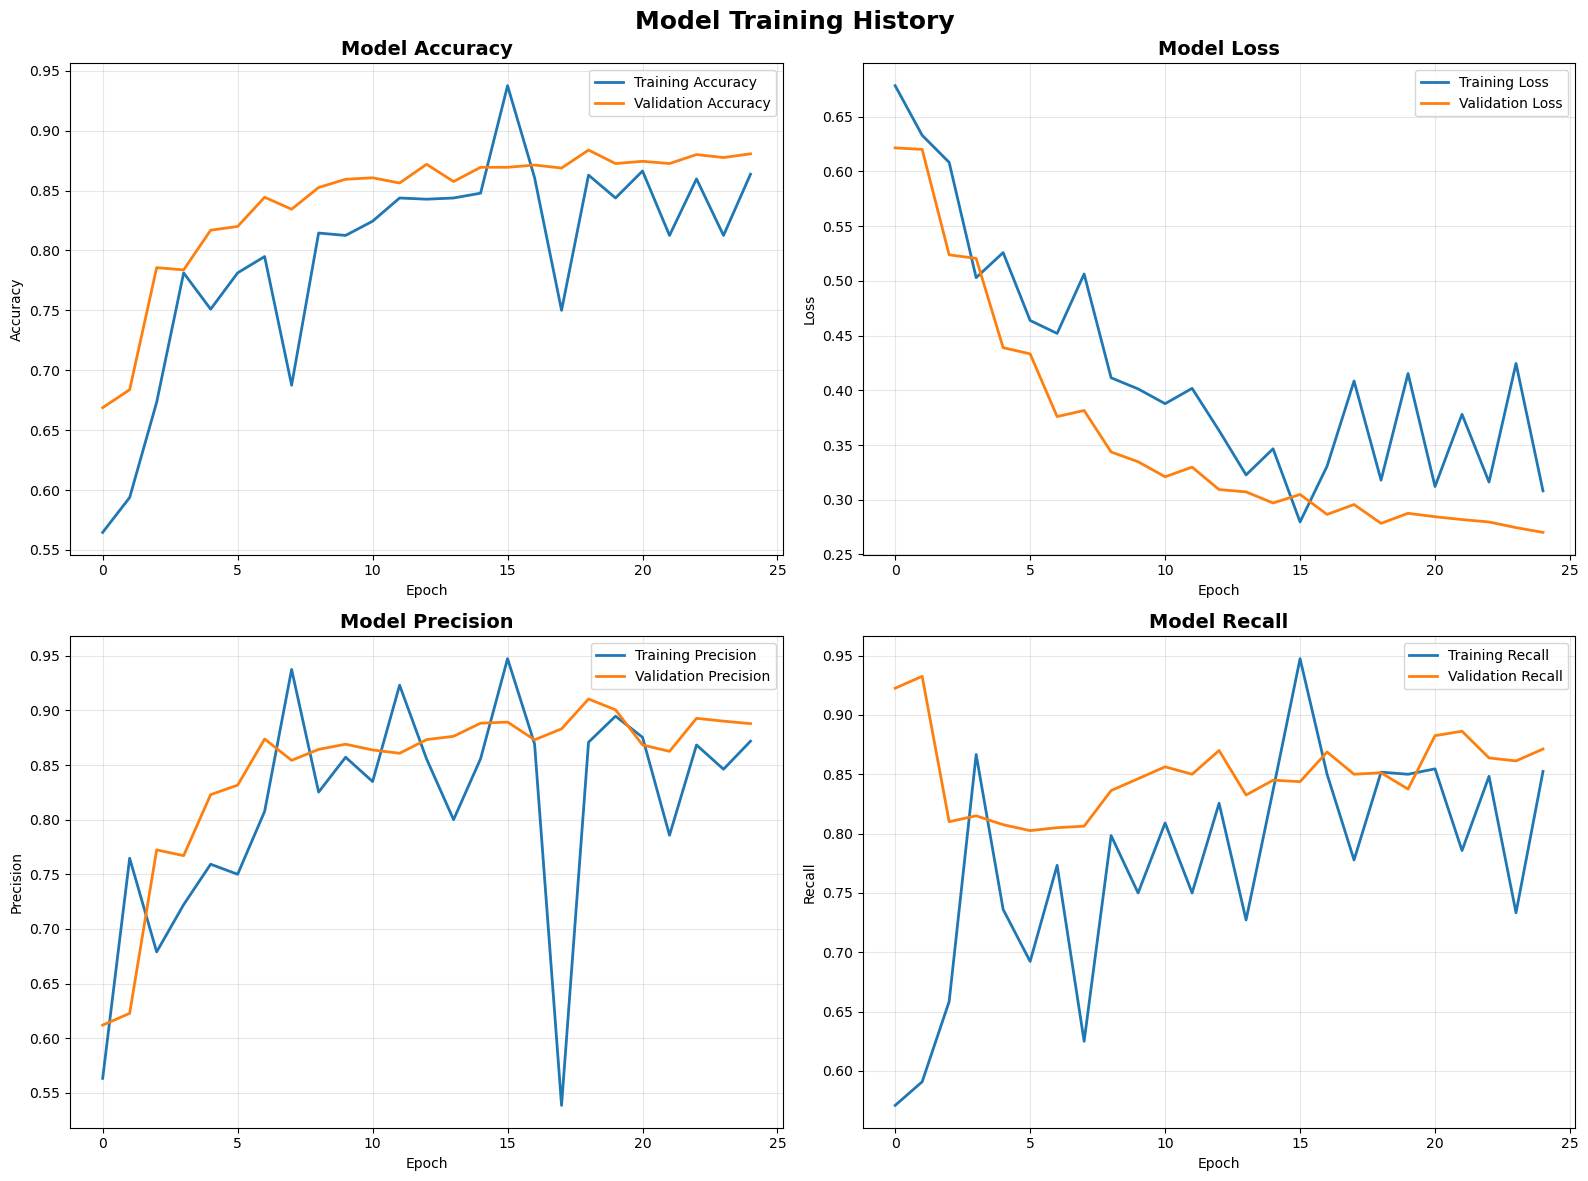

In [12]:
# Visualization 4: Training and Validation Metrics
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Model Training History', fontsize=18, fontweight='bold')

# Accuracy
axes[0, 0].plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
axes[0, 0].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
axes[0, 0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Loss
axes[0, 1].plot(history.history['loss'], label='Training Loss', linewidth=2)
axes[0, 1].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
axes[0, 1].set_title('Model Loss', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Precision
axes[1, 0].plot(history.history['precision'], label='Training Precision', linewidth=2)
axes[1, 0].plot(history.history['val_precision'], label='Validation Precision', linewidth=2)
axes[1, 0].set_title('Model Precision', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Precision')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Recall
axes[1, 1].plot(history.history['recall'], label='Training Recall', linewidth=2)
axes[1, 1].plot(history.history['val_recall'], label='Validation Recall', linewidth=2)
axes[1, 1].set_title('Model Recall', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Recall')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 11. Model Evaluation - Test Set Predictions

In [13]:
# Generate predictions on test set
print("Evaluating model on test set...\n")

test_generator.reset()
predictions_prob = model.predict(test_generator, verbose=1)
predictions = (predictions_prob > 0.5).astype(int).flatten()

# Get true labels
true_labels = test_generator.classes

print(f"\nPredictions generated: {len(predictions)}")
print(f"True labels: {len(true_labels)}")

Evaluating model on test set...

64/64 ━━━━━━━━━━━━━━━━━━━━ 432s 7s/step

Predictions generated: 2023
True labels: 2023


## 12. Comprehensive Evaluation Metrics

In [14]:
# Calculate all metrics
test_accuracy = accuracy_score(true_labels, predictions)
test_precision = precision_score(true_labels, predictions)
test_recall = recall_score(true_labels, predictions)
test_f1 = f1_score(true_labels, predictions)
test_auc = roc_auc_score(true_labels, predictions_prob)

# Confusion matrix
cm = confusion_matrix(true_labels, predictions)

print("="*60)
print("MODEL EVALUATION METRICS")
print("="*60)
print(f"\nAccuracy:  {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"Precision: {test_precision:.4f} ({test_precision*100:.2f}%)")
print(f"Recall:    {test_recall:.4f} ({test_recall*100:.2f}%)")
print(f"F1-Score:  {test_f1:.4f} ({test_f1*100:.2f}%)")
print(f"ROC-AUC:   {test_auc:.4f} ({test_auc*100:.2f}%)")
print("\n" + "="*60)

# Classification report
print("\nDetailed Classification Report:")
print("="*60)
print(classification_report(true_labels, predictions, target_names=['Cats', 'Dogs']))

# Save metrics to file
metrics = {
    'accuracy': float(test_accuracy),
    'precision': float(test_precision),
    'recall': float(test_recall),
    'f1_score': float(test_f1),
    'roc_auc': float(test_auc),
    'timestamp': datetime.now().isoformat()
}

with open(MODEL_DIR / 'metrics.json', 'w') as f:
    json.dump(metrics, f, indent=4)

print("\nMetrics saved to models/metrics.json")

MODEL EVALUATION METRICS

Accuracy:  0.9051 (90.51%)
Precision: 0.8965 (89.65%)
Recall:    0.9160 (91.60%)
F1-Score:  0.9062 (90.62%)
ROC-AUC:   0.9711 (97.11%)


Detailed Classification Report:
              precision    recall  f1-score   support

        Cats       0.91      0.89      0.90      1011
        Dogs       0.90      0.92      0.91      1012

    accuracy                           0.91      2023
   macro avg       0.91      0.91      0.91      2023
weighted avg       0.91      0.91      0.91      2023


Metrics saved to models/metrics.json


## 13. Confusion Matrix Visualization

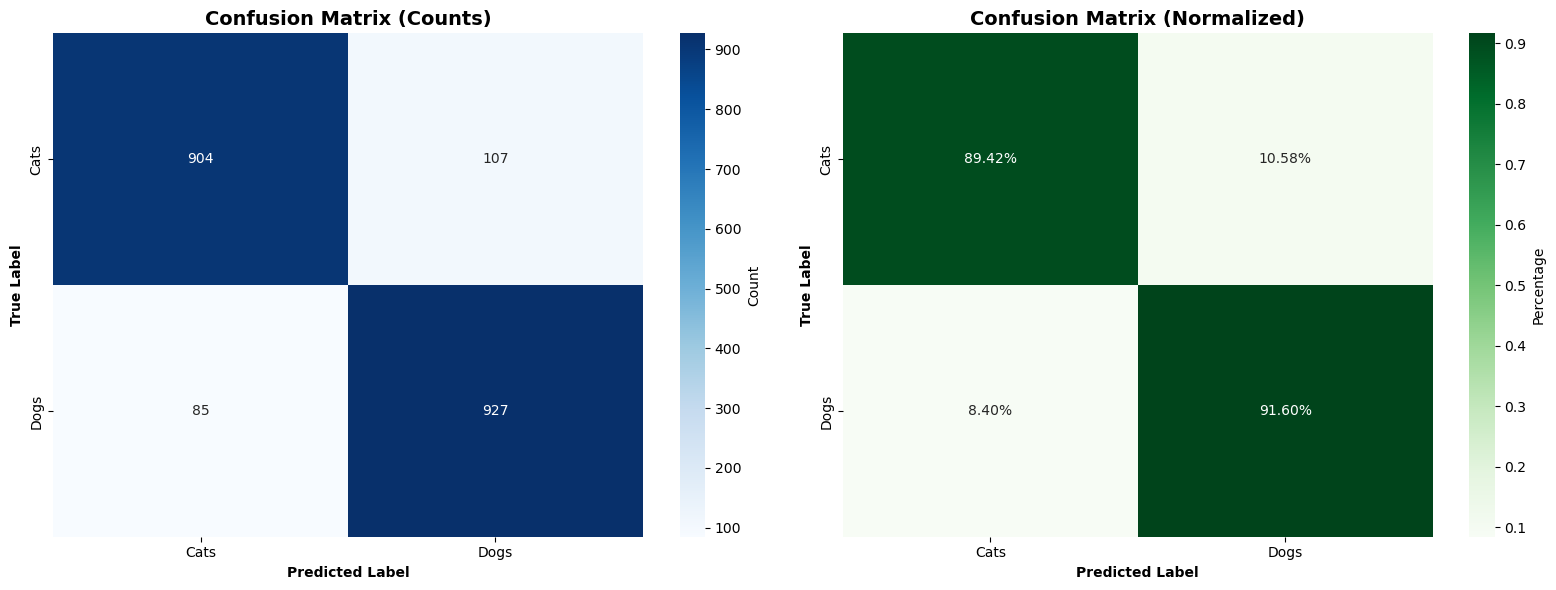

True Negatives (Cats correctly predicted):  904
False Positives (Cats predicted as Dogs):   107
False Negatives (Dogs predicted as Cats):   85
True Positives (Dogs correctly predicted):  927


In [15]:
# Visualization 5: Confusion Matrix
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Absolute counts
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Cats', 'Dogs'], yticklabels=['Cats', 'Dogs'],
            cbar_kws={'label': 'Count'})
axes[0].set_title('Confusion Matrix (Counts)', fontsize=14, fontweight='bold')
axes[0].set_ylabel('True Label', fontweight='bold')
axes[0].set_xlabel('Predicted Label', fontweight='bold')

# Normalized
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Greens', ax=axes[1],
            xticklabels=['Cats', 'Dogs'], yticklabels=['Cats', 'Dogs'],
            cbar_kws={'label': 'Percentage'})
axes[1].set_title('Confusion Matrix (Normalized)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('True Label', fontweight='bold')
axes[1].set_xlabel('Predicted Label', fontweight='bold')

plt.tight_layout()
plt.show()

print(f"True Negatives (Cats correctly predicted):  {cm[0, 0]}")
print(f"False Positives (Cats predicted as Dogs):   {cm[0, 1]}")
print(f"False Negatives (Dogs predicted as Cats):   {cm[1, 0]}")
print(f"True Positives (Dogs correctly predicted):  {cm[1, 1]}")

## 14. ROC Curve Visualization

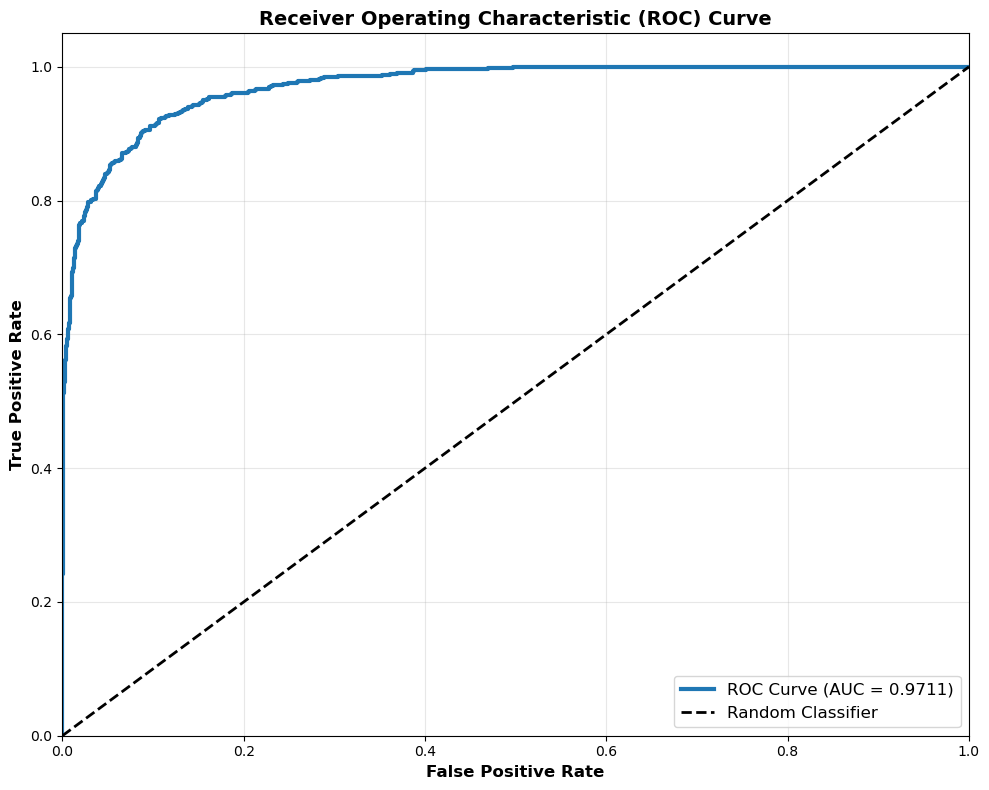

In [16]:
# Visualization 6: ROC Curve
fpr, tpr, thresholds = roc_curve(true_labels, predictions_prob)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, linewidth=3, label=f'ROC Curve (AUC = {test_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=12, fontweight='bold')
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 15. Sample Predictions Visualization

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


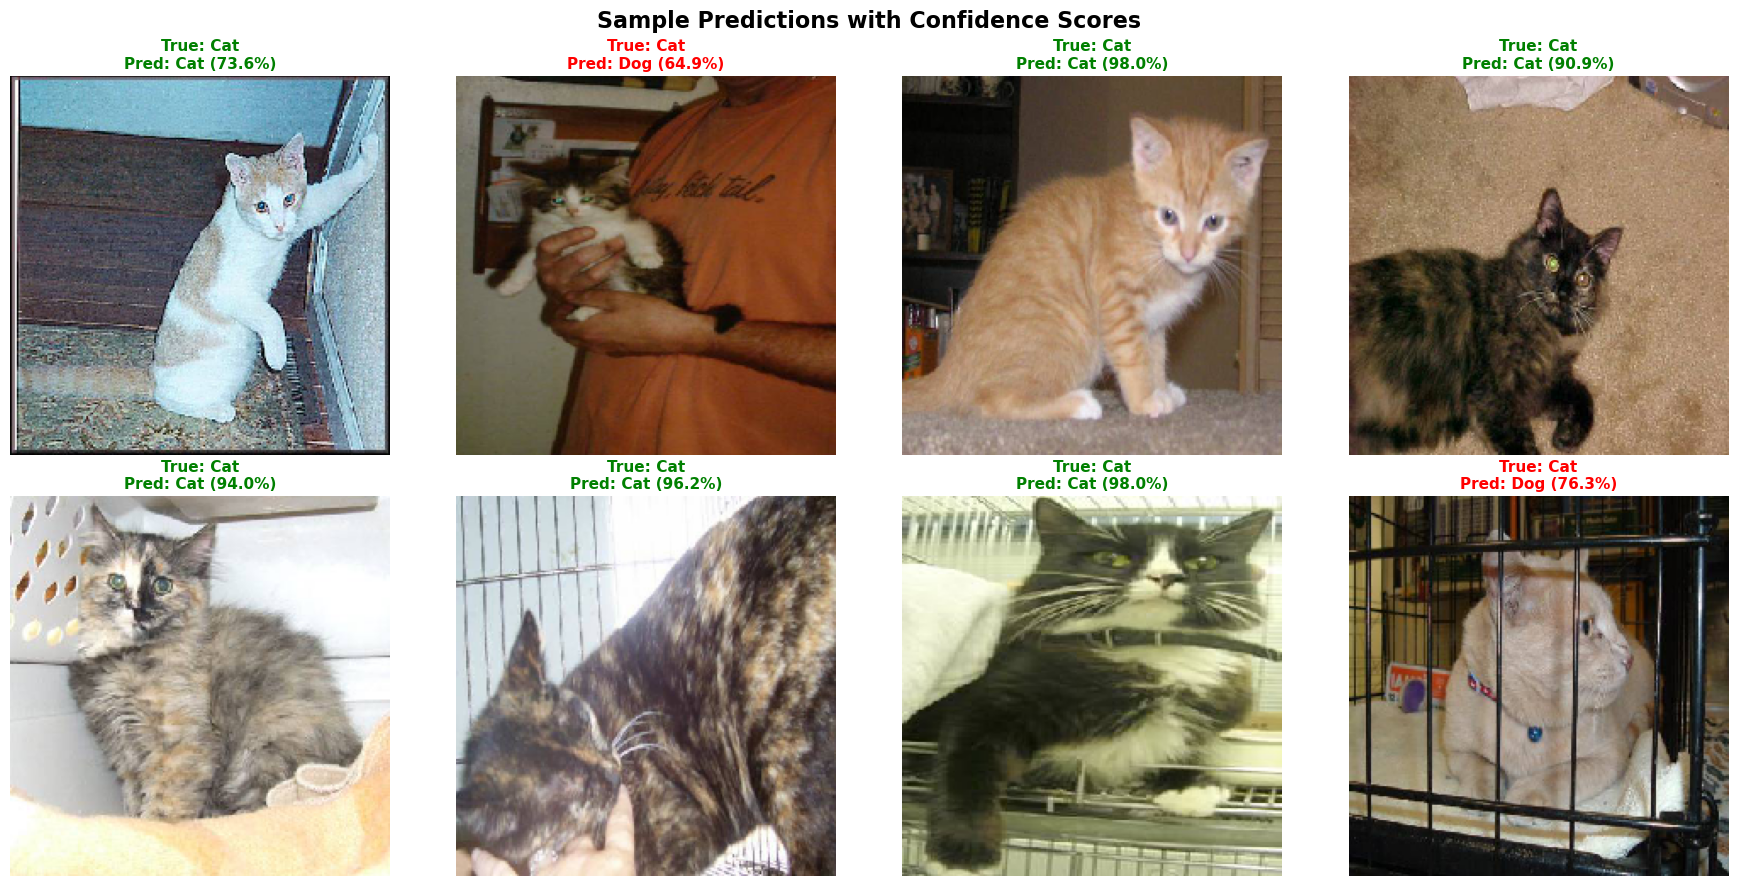

In [17]:
# Visualization 7: Sample Predictions
test_generator.reset()
sample_batch = next(test_generator)
sample_images = sample_batch[0][:8]
sample_labels = sample_batch[1][:8].astype(int)
sample_predictions = model.predict(sample_images)

fig, axes = plt.subplots(2, 4, figsize=(18, 9))
fig.suptitle('Sample Predictions with Confidence Scores', fontsize=16, fontweight='bold')

for idx, ax in enumerate(axes.flat):
    ax.imshow(sample_images[idx])
    
    true_class = 'Dog' if sample_labels[idx] == 1 else 'Cat'
    pred_prob = sample_predictions[idx][0]
    pred_class = 'Dog' if pred_prob > 0.5 else 'Cat'
    confidence = pred_prob if pred_prob > 0.5 else 1 - pred_prob
    
    color = 'green' if true_class == pred_class else 'red'
    title = f'True: {true_class}\nPred: {pred_class} ({confidence*100:.1f}%)'
    
    ax.set_title(title, fontweight='bold', color=color, fontsize=11)
    ax.axis('off')

plt.tight_layout()
plt.show()

## 16. Save Final Model

In [19]:
# Save model in multiple formats
model.save(MODEL_DIR / 'cats_dogs_model.h5')
model.save(MODEL_DIR / 'cats_dogs_model.keras')

print("Model saved successfully!")
print(f"  - H5 format: {MODEL_DIR / 'cats_dogs_model.h5'}")
print(f"  - Keras format: {MODEL_DIR / 'cats_dogs_model.keras'}")

# Save model configuration
model_config = {
    'architecture': 'VGG16 Transfer Learning',
    'input_shape': list(IMG_SIZE) + [3],
    'classes': CLASS_NAMES,
    'batch_size': BATCH_SIZE,
    'epochs_trained': len(history.history['accuracy']),
    'optimizer': 'Adam',
    'learning_rate': LEARNING_RATE,
    'created_at': datetime.now().isoformat()
}

with open(MODEL_DIR / 'model_config.json', 'w') as f:
    json.dump(model_config, f, indent=4)

print("\nModel configuration saved to models/model_config.json")

Model saved successfully!
  - H5 format: /home/twize/Desktop/ML-summatives/models/cats_dogs_model.h5
  - Keras format: /home/twize/Desktop/ML-summatives/models/cats_dogs_model.keras

Model configuration saved to models/model_config.json


## 17. Model Summary and Insights

In [20]:
print("="*80)
print(" "*25 + "MODEL TRAINING SUMMARY")
print("="*80)
print(f"\nDataset Information:")
print(f"  Total Training Samples:   {train_generator.samples + validation_generator.samples:,}")
print(f"  Total Test Samples:       {test_generator.samples:,}")
print(f"  Image Size:               {IMG_SIZE}")
print(f"  Number of Classes:        {len(CLASS_NAMES)}")

print(f"\nModel Architecture:")
print(f"  Base Model:               VGG16 (Pretrained on ImageNet)")
print(f"  Total Parameters:         {model.count_params():,}")
print(f"  Trainable Parameters:     {sum([tf.size(w).numpy() for w in model.trainable_weights]):,}")

print(f"\nTraining Configuration:")
print(f"  Optimizer:                Adam")
print(f"  Learning Rate:            {LEARNING_RATE}")
print(f"  Batch Size:               {BATCH_SIZE}")
print(f"  Epochs Completed:         {len(history.history['accuracy'])}")

print(f"\nOptimization Techniques Applied:")
print(f"  - Transfer Learning (VGG16)")
print(f"  - Data Augmentation")
print(f"  - Early Stopping")
print(f"  - Learning Rate Reduction")
print(f"  - Dropout Regularization")

print(f"\nFinal Performance Metrics:")
print(f"  Accuracy:                 {test_accuracy*100:.2f}%")
print(f"  Precision:                {test_precision*100:.2f}%")
print(f"  Recall:                   {test_recall*100:.2f}%")
print(f"  F1-Score:                 {test_f1*100:.2f}%")
print(f"  ROC-AUC:                  {test_auc*100:.2f}%")

print("\n" + "="*80)
print("Model training and evaluation completed successfully!")
print("="*80)

                         MODEL TRAINING SUMMARY

Dataset Information:
  Total Training Samples:   8,005
  Total Test Samples:       2,023
  Image Size:               (224, 224)
  Number of Classes:        2

Model Architecture:
  Base Model:               VGG16 (Pretrained on ImageNet)
  Total Parameters:         14,879,041
  Trainable Parameters:     164,353

Training Configuration:
  Optimizer:                Adam
  Learning Rate:            0.0001
  Batch Size:               32
  Epochs Completed:         25

Optimization Techniques Applied:
  - Transfer Learning (VGG16)
  - Data Augmentation
  - Early Stopping
  - Learning Rate Reduction
  - Dropout Regularization

Final Performance Metrics:
  Accuracy:                 90.51%
  Precision:                89.65%
  Recall:                   91.60%
  F1-Score:                 90.62%
  ROC-AUC:                  97.11%

Model training and evaluation completed successfully!
